## A model that predicts whether a given transaction is fraudulent

## Unknown feature names

## The model will be evaluated using the area under the ROC curve

**ROC takes into consideration both True Positives (ideally 1) and False Negatives (ideally 0). As these are the metrics that are to be optimized (TP) and minimized (FP), the ROC is the most suitable metric. Had resampled data not be used, the ROC would not have been as effective. In this case, replace the x-axis (1 - specificity) with Precision (TP/ TP + FP), because precision does not include the number of True Negatives in its calculation, and is not affected by the imbalance.**

**The desired metric was Recall, indicating the ratio scoring for True Positive. Essentially, the ability of the classifier to find all the positive samples. There wouldnt be a drastic change in how the problem was approached as both metrics (ROC & Recall) take the True Positive into consideration. For my desired metric, Recall, I would utilize the classification report instead of the roc_auc_score.**

**The decision for the threshold probability to block a transaction would be a threshold that provides the client with a comfortable probability of a transaction being blocked (sensitivity), without suffering too many False Positives (1 - sensitivity)**

- line 1: y_proba = model.predict_proba(X_test)[:, 1]
- line 2: y_pred2 = (y_proba >= .3).astype(int)

- Obtaining the y_proba, the threshold can be altered (eg. 0.5 -> 0.3) so as to improve Sensitivity.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.ensemble import StackingClassifier


## Loading the data

In [2]:
df = pd.read_csv('\\Users\\mvall\\Downloads\\sample.csv', delimiter=',') # Read File

In [3]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-0.247824,6.425853,-6.485658,-8.241462,NaN,0.03%,Tuesday,-9.808905,4.753455,2.537819,...,0.592543,14.967527,6.691044,-0.275572,2.518542,4.637431,-14.296510,1.898115,-1.225228,0
1,2.623274,-2.808263,5.321746,-2.437653,0.614041,0.02%,Wednesday,10.710053,1.608882,-2.027541,...,-1.712788,-3.638637,-2.256492,2.703101,1.760729,2.660614,1.182922,-3.203078,0.711018,0
2,-5.460551,5.997701,-4.614194,-6.035128,-1.986438,-0.0%,Tuesday,-3.364649,-2.493473,1.429913,...,2.206956,7.292558,10.095556,1.601155,1.710645,-12.519434,-5.261707,2.032666,-6.445528,0
3,1.566307,-0.080517,0.064754,6.063193,-2.253075,0.0%,Thurday,-6.111982,-1.796377,-3.169510,...,-3.841669,5.189840,10.291069,-3.642396,0.674300,-1.104317,-3.922342,-0.613947,7.275179,0
4,0.750715,15.656095,-6.778600,11.251037,-0.308200,0.0%,Wednesday,2.498892,-0.323229,-2.624680,...,8.933781,-7.295794,-11.246059,-4.876594,3.395415,-2.646844,-5.273267,-5.259536,-3.240523,0


In [4]:
label = df['y']

## EDA

In [5]:
df.shape

(8000, 101)

**Observation**
- 95 numerical columns
- 6 categorical columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Columns: 101 entries, x0 to y
dtypes: float64(94), int64(1), object(6)
memory usage: 6.2+ MB


**Identify object columns**

In [52]:
df.dtypes[df.dtypes=='object']

x6     object
x20    object
x27    object
dtype: object

In [8]:
df[['x5','x6','x20','x27','x49','x57']]

,x5,x6,x20,x27,x49,x57
0,0.03%,Tuesday,Aug,Afternoon,False,$1578.34
1,0.02%,Wednesday,Jul,Afternoon,False,$767.76
2,-0.0%,Tuesday,Aug,Evening,False,$931.06
3,0.0%,Thurday,Aug,Afternoon,True,$2124.52
4,0.0%,Wednesday,Jul,Evening,False,$-3055.67
...,...,...,...,...,...,...
7995,0.01%,Tuesday,Jun,Afternoon,False,$-1664.04
7996,0.0%,Tuesday,May,Afternoon,False,$-42.81
7997,-0.01%,Wednesday,Aug,Afternoon,True,$220.59
7998,-0.0%,Tuesday,Aug,Evening,True,$467.47


In [9]:
df['x5'].value_counts()

0.01%     1929
-0.01%    1881
0.0%      1531
-0.0%     1514
0.02%      479
-0.02%     462
-0.03%      60
0.03%       48
0.04%        1
-0.04%       1
Name: x5, dtype: int64

**Observation**
- `Column **x57**` is a dollar value column. The '$' will be removed and the column will be converted to numerical continuious data.
- `Column **x5**` only contains serveral values from 0.04% to -0.04%. It will be handled first based on categorical data and then, converted to numerical. 
- For other columns, they will be treated as categorical values.

In [10]:
df.drop(['x5','x6','x20','x27','x49','x57'],axis =1).describe()

,x0,x1,x2,x3,x4,x7,x8,x9,x10,x11,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
count,7916.000000,7924.000000,7926.000000,7934.000000,7919.000000,7909.000000,7921.000000,7914.000000,7911.000000,7925.000000,...,7913.000000,7907.000000,7903.000000,7930.000000,7930.000000,7913.000000,7914.000000,7923.000000,7923.000000,8000.000000
mean,0.060228,0.407989,0.054322,-0.023308,-0.004516,0.005298,0.006460,0.054020,0.082194,-0.162486,...,-0.010624,-0.093474,0.062183,0.043515,0.555696,0.097914,-0.094866,-0.031607,-0.107921,0.054875
std,4.114402,14.047469,7.335695,8.744338,1.495770,7.825992,2.060713,4.808131,6.090958,9.637473,...,7.680308,9.936610,8.800644,4.431941,1.693398,7.904771,6.806242,6.272912,6.345949,0.227750
min,-18.252266,-42.459763,-27.966393,-31.413403,-5.185877,-30.006046,-9.744478,-17.118829,-23.412152,-36.495817,...,-27.810191,-33.876898,-30.762278,-16.942654,-6.503762,-28.708333,-27.631360,-22.814032,-24.159002,0.000000
25%,-2.708436,-9.746864,-5.018364,-5.904680,-1.001892,-5.332021,-1.388365,-3.206162,-3.979275,-6.673348,...,-5.113941,-6.814237,-5.947130,-2.927609,-0.526532,-5.396910,-4.492095,-4.199087,-4.362669,0.000000
50%,0.042683,-0.831805,0.008158,-0.036743,0.008718,-0.012167,-0.000204,0.127904,0.156267,-0.113515,...,0.042126,-0.237591,0.193627,0.054766,0.572391,0.110662,-0.051194,0.018044,-0.079668,0.000000
75%,2.870351,9.498792,4.911921,5.851433,0.987828,5.288608,1.337205,3.390917,4.180005,6.322518,...,5.200893,6.551684,6.163712,3.033703,1.701990,5.569025,4.509073,4.161221,4.231148,0.000000
max,16.464349,58.037828,27.964211,29.580564,6.404181,25.619078,7.797751,16.574194,20.708372,34.389640,...,29.811154,36.301709,29.069874,18.347966,6.474684,29.928906,24.533676,23.643567,23.816776,1.000000


**Observation:**The values in these numerical columns are well distributed around mean.

### Checking missing values

In [17]:
df.isnull().sum()/df.isnull().count()

x0     0.010500
x1     0.009500
x2     0.009250
x3     0.008250
x4     0.010125
         ...   
x96    0.010875
x97    0.010750
x98    0.009625
x99    0.009625
y      0.000000
Length: 101, dtype: float64

In [19]:
df['y'].isnull().sum()

0

## NOTES
- y (target) column has no null values
- all other columns have missing values
- dropping rows of all missing values will remove every row
- missing values are approx 1% of total data
- therefore, the data will be imputed with the mean (numerical data) and the mode (categorical data)
- data will be split into train and test (with minor data leakage)

### Data Split

There are 2 ways of splitting the data:
1. Split the data into train, validation and test data. 
      - Pro: Avoids any data leakage.
      - Con: More complicated and takes more time.
2. Only split data into two parts: train and test.
      - Pro: Easier and quick
      - Con: When filling the missing values with mean, this will cause data leakage when validating the model.

**'Split' Decision:** I have chosen the second method, and while this may cause the data leakage, the impact of only 1% data leakage of a column will beslim on the entire model.

**For the record:** train, validation, and test splitting would be the ideal method

In [11]:
X = df.drop(columns='y')
label = df['y']

In [12]:
X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.20, random_state=42)

## Data Wrangling

## Data Imputation to be done after Train/test splitting to avoid data leakage

### Convert column x57 numerical type

In [13]:
datasets = [X_train, X_test]

for d in datasets:
    d['x57'] = d['x57'].str.lstrip('$').astype(float)

C:\Users\mvall\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Imputing the mode

In [14]:
datasets = [X_train, X_test]

for d in datasets:
    for cl in ['x5','x6','x20','x27','x49']:
        d[cl]= d[cl].fillna(d[cl].mode()[0],axis=0)       

C:\Users\mvall\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Convert to numerical

In [15]:
datasets = [X_train, X_test]

for d in datasets:
    d['x5'] = d['x5'].str.rstrip('%').apply(float)/100

C:\Users\mvall\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
datasets = [X_train, X_test]

for d in datasets:
    d['x49'] = d['x49'].astype(int)

C:\Users\mvall\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Impute the mean

In [17]:
datasets = [X_train, X_test]
categorical_cols = ['x5','x6','x20','x27','x49']
nuclist = list(X_train.columns)
for df in datasets:
    for cl in nuclist:
        if cl not in categorical_cols:
            df[cl] = df[cl].fillna(df[cl].mean(),axis=0)
    





C:\Users\mvall\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Checking for any null values

In [18]:
datasets = [X_train, X_test] # CHECK ISNULL

for df in datasets:
    print(df.isnull().sum().sum())

0
0


## One Hot Encoding

In [19]:
X2_train = pd.get_dummies(X_train, drop_first=True)
X2_test = pd.get_dummies(X_test, drop_first=True)

In [20]:
y_train = label_train
y_test = label_test

In [21]:
X2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 1467 to 7270
Columns: 115 entries, x0 to x27_Night
dtypes: float64(96), int32(1), uint8(18)
memory usage: 4.9 MB


In [22]:
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 2215 to 6832
Columns: 115 entries, x0 to x27_Night
dtypes: float64(96), int32(1), uint8(18)
memory usage: 1.2 MB


## Baseline Model

### Target data imbalanced

<AxesSubplot:>

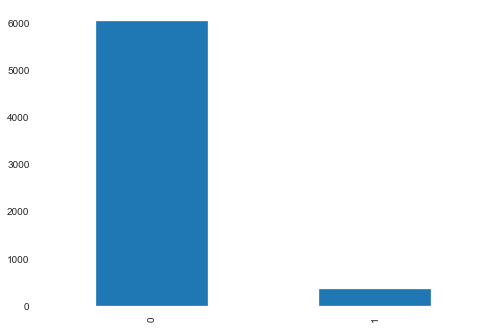

In [23]:
y_train.value_counts().plot(kind = 'bar')

In [24]:
pd.Series(y_train).value_counts(normalize=True)

0    0.94375
1    0.05625
Name: y, dtype: float64

## RESAMPLE

In [25]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X2_train, y_train)
X_test_resampled, y_test_resampled = ros.fit_resample(X2_test, y_test)

print(X_train_resampled.shape, y_train_resampled.shape,X_test_resampled.shape, y_test_resampled.shape)

pd.Series(y_train_resampled).value_counts()

(12080, 115) (12080,) (3042, 115) (3042,)


1    6040
0    6040
Name: y, dtype: int64

## SCALED

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)

X_test_scaled = scaler.transform(X_test_resampled)

### Since this is a fraud detection system, the focus is on the accuracy of detecting the fraud -- False Negative. 
### Therefore the `recall` metric is very important in addtion to ROC.

In [27]:
from sklearn.model_selection import cross_validate 
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
score  = cross_validate(lr,X_train_scaled, y_train_resampled, cv=5, scoring=['recall'] ) 

score['test_recall'].mean()

0.7917218543046357

In [28]:
lr.fit(X_train_scaled,y_train_resampled)
y_pred_resampled = lr.predict(X_test_scaled)

In [29]:
from sklearn.metrics import classification_report 

print(classification_report(y_test_resampled,y_pred_resampled)) 

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1521
           1       0.75      0.73      0.74      1521

    accuracy                           0.75      3042
   macro avg       0.75      0.75      0.75      3042
weighted avg       0.75      0.75      0.75      3042



### Baseline model score
### Recall is 0.73

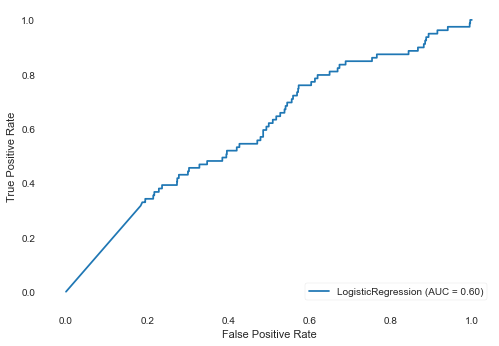

In [30]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(lr, X2_test,y_test)

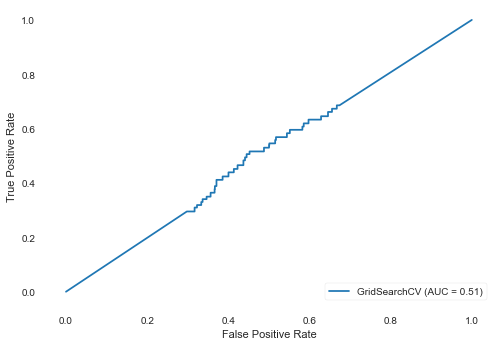

In [56]:
plot_roc_curve(lr, X_test_resampled,y_test_resampled)

In [ ]:

roc_auc_score(y_test_resampled,y_pred_resampled)

## Pipeline Models

### Single models will be created first as the bank is needs a fast model for daily live operations.
### Usually a single machine learning model is faster than stacking models.

### Logistic Regression
### The model is now being fine tuned with piopeline and Gridsearch

In [53]:

grid_param = [{"logisticregression__C": np.logspace(0, 4, 10),
              "logisticregression__random_state":[42]}]

gridsearch = GridSearchCV(make_pipeline(StandardScaler(), LogisticRegression()),grid_param,cv=5,verbose=0)

lr = gridsearch.fit(X_train_resampled,y_train_resampled)


print(lr.best_estimator_)

C:\Users\mvall\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\mvall\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=21.544346900318832, random_state=42))])


In [54]:
y_lr_pred_resampled = lr.predict(X_test_resampled)
print(classification_report(y_test_resampled,y_lr_pred_resampled))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      1521
           1       0.76      0.73      0.74      1521

    accuracy                           0.75      3042
   macro avg       0.75      0.75      0.75      3042
weighted avg       0.75      0.75      0.75      3042



### Recall is .73 for tuned Logistic Regression model

In [55]:

roc_auc_score(y_test_resampled,y_lr_pred_resampled)

0.7458908612754768

### AUC ROC is .75 for tuned Logistic Regression model

## Random Forest

In [ ]:

grid_param = [{"n_estimators": [10,50,100],
               "max_depth":[5,8,15,30,None],
               "min_samples_leaf":[1,2,5,10,15],
               "max_leaf_nodes": [2, 5,10]}]

gridsearch = GridSearchCV(RandomForestClassifier(),grid_param,cv=5,verbose=0, n_jobs = -1)

best_model_rf = gridsearch.fit(X_train_resampled,y_train_resampled)


print(best_model_rf.best_estimator_)


In [ ]:
y_rf_pred_resampled = best_model_rf.predict(X_test_resampled)
print(classification_report(y_test_resampled,y_rf_pred_resampled))

### Recall is 0.79 for Random Forest

In [ ]:

roc_auc_score(y_test_resampled,y_rf_pred_resampled)

### AUC ROC is .79 for Random Forest model

### XGBoostClassifier

In [ ]:

pipe = Pipeline([('scalar1',StandardScaler()),("classifier", XGBClassifier())])

estimators = [('xgb', XGBClassifier())]

grid_param = {'classifier__min_child_weight': [1, 5, 10],
              'classifier__gamma': [0.5, 1, 1.5, 2, 5],
              'classifier__subsample': [0.6, 0.8, 1.0],
              'classifier__colsample_bytree': [0.6, 0.8, 1.0],
              'classifier__max_depth': [3, 4, 5]
              }


gridsearch = GridSearchCV(pipe,grid_param,cv=5,verbose=0)

xgb = gridsearch.fit(X_train_resampled,y_train_resampled)


print(xgb.best_estimator_)


In [ ]:
y_xgb_pred_resampled = xgb.predict(X_test_resampled)
print(classification_report(y_test_resampled,y_xgb_pred_resampled))

### Recall score of 0.62 for XGBoost model

In [ ]:

plot_roc_curve(xgb,X_test_resampled,y_test_resampled)

In [ ]:
roc_auc_score(y_test_resampled,y_xgb_pred_resampled)

### AUC ROC is 0.80 for XGBoost model

## STACKING

In [ ]:

estimators = [
    ('lr', LogisticRegression(C=21.544346900318832, random_state=42)),
    ('rf', RandomForestClassifier(max_depth=8, max_leaf_nodes=10, min_samples_leaf=10,
                       n_estimators=50)),
    ('xb', XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.6, gamma=0.5, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=5, min_child_weight=1,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.6, tree_method='exact',
                               validate_parameters=1, verbosity=None)),

    
]

st_model = StackingClassifier(
    estimators=estimators, final_estimator=RandomForestClassifier()
)

In [ ]:
st_model.fit(X_train_resampled,y_train_resampled)

In [ ]:
y_st_pred_resampled = st_model.predict(X_test_resampled)
print(classification_report(y_test_resampled,y_st_pred_resampled))

### Recall is 0.28 for Stacking Model

In [ ]:
plot_roc_curve(st_model,X_test_resampled,y_test_resampled)

In [ ]:
roc_auc_score(y_test_resampled,y_st_pred_resampled)

### AUC ROC is 0.64 for Stacking model

## Model Recommendation

### Random Forest: a mid/high run rate (over 45 min) but best all around AUC ROC & Recall scores
### XGBoost: while this model had (barely) the highest AUC ROC score, it's low Recall score (0.62) and it's extremely high runtime time (many hours!) disqualified it as the recommended model

## Pipeline

### RESAMPLING

In [ ]:

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = ros.fit_resample(X2_train, y_train)

### Build the model

In [ ]:

grid_param = [{"n_estimators": [10,50,100],
               "max_depth":[5,8,15,30,None],
               "min_samples_leaf":[1,2,5,10,15],
               "max_leaf_nodes": [2, 5,10]}]

gridsearch = GridSearchCV(RandomForestClassifier(),grid_param,cv=5,verbose=0, n_jobs = -1)

### Train the model

In [ ]:

model= gridsearch.fit(X_train_resampled,y_train_resampled)

### Prediction

In [ ]:

X_test_resampled, y_test_resampled = ros.fit_resample(X2_test, y_test)

In [ ]:
y_pred = model.predict(X_test_resampled)

### Model evaluation

In [ ]:

roc_auc_score(y_test_resampled,y_pred)

## Changing the probability threshhold

### Threshhold 25%

In [46]:
y_proba = lr.predict_proba(X_test_scaled)[:, 1] 

In [47]:
y_pred2_resampled = (y_proba >= .25).astype(int)

In [48]:
print(classification_report(y_test_resampled,y_pred2_resampled)) 

              precision    recall  f1-score   support

           0       0.85      0.53      0.66      1521
           1       0.66      0.91      0.76      1521

    accuracy                           0.72      3042
   macro avg       0.76      0.72      0.71      3042
weighted avg       0.76      0.72      0.71      3042



### RECALL of .87

### Threshhold 75%

In [49]:
y_proba = lr.predict_proba(X_test_scaled)[:, 1] 

In [50]:
y_pred3_resampled = (y_proba >= .75).astype(int)

In [51]:
print(classification_report(y_test_resampled,y_pred3_resampled)) 

              precision    recall  f1-score   support

           0       0.64      0.92      0.76      1521
           1       0.85      0.49      0.63      1521

    accuracy                           0.70      3042
   macro avg       0.75      0.70      0.69      3042
weighted avg       0.75      0.70      0.69      3042



### RECALL of .47